/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


SAC Episode: 1, Reward: -0.9514656372201784
SAC Episode: 2, Reward: -0.9421649233026077
SAC Episode: 3, Reward: -1.0264692260070531
SAC Episode: 4, Reward: -1.112919683098061
SAC Episode: 5, Reward: -0.9633998145819792
SAC Episode: 6, Reward: -1.0889973629450214
SAC Episode: 7, Reward: -1.0157252325992605
SAC Episode: 8, Reward: -0.9951655090252228
SAC Episode: 9, Reward: -1.0839780210253438
SAC Episode: 10, Reward: -1.0603749448056154
SAC Episode: 11, Reward: -0.9434846695933666
SAC Episode: 12, Reward: -1.050153298545357
SAC Episode: 13, Reward: -0.9788693884364533
SAC Episode: 14, Reward: -1.0254780986788496
SAC Episode: 15, Reward: -0.967841215727286
SAC Episode: 16, Reward: -0.9784874448912662
SAC Episode: 17, Reward: -1.0489307804011492
SAC Episode: 18, Reward: -1.1222528563558514
SAC Episode: 19, Reward: -0.9790837771225736
SAC Episode: 20, Reward: -0.9827883426888661
SAC Episode: 21, Reward: -1.0024535773014003
SAC Episode: 22, Reward: -1.0281383411677016
SAC Episode: 23, Rewar

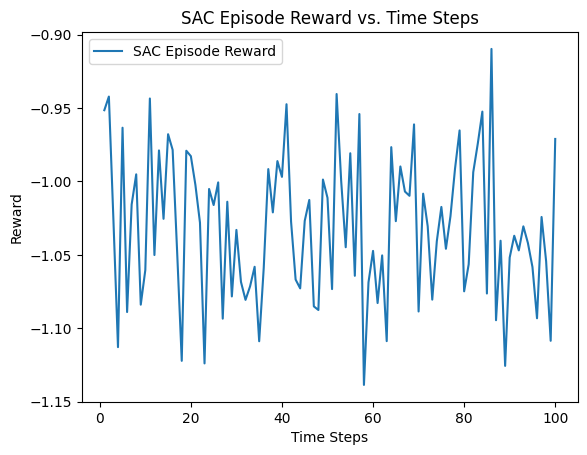

In [5]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal

actor_lr_sac = 0.001
critic_lr_sac = 0.002
alpha_sac = 0.2
gamma_sac = 0.99
tau_sac = 0.005
buffer_size_sac = 10000
target_entropy_sac = -3
policy_freq_sac = 2
batch_size_sac = 64

env = gym.make("MountainCarContinuous-v0")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

class ActorSAC(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(ActorSAC, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)
        self.max_action = max_action
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action_mean = torch.tanh(self.fc3(x)) * self.max_action
        return action_mean

class CriticSAC(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticSAC, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SACAgent:
    def __init__(self, state_dim, action_dim, max_action_sac, alpha_lr_sac=0.0003):
        self.actor = ActorSAC(state_dim, action_dim, max_action_sac)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr_sac)

        self.critic1 = CriticSAC(state_dim, action_dim)
        self.critic2 = CriticSAC(state_dim, action_dim)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=critic_lr_sac)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=critic_lr_sac)

        self.log_alpha = torch.zeros(1, requires_grad=True)
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=alpha_lr_sac)

        self.replay_buffer = []
        self.pointer = 0
        self.buffer = []

        self.max_action = max_action_sac

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1))
        mean = self.actor(state)
        action_dist = Normal(mean, torch.ones_like(mean) * 0.1)
        action = action_dist.sample()
        return action.numpy().flatten()

    def train(self):
        if len(self.replay_buffer) < batch_size_sac:
            return

        batch = np.random.choice(len(self.replay_buffer), batch_size_sac, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.replay_buffer[i] for i in batch])

        state_batch = torch.FloatTensor(states)
        action_batch = torch.FloatTensor(actions)
        reward_batch = torch.FloatTensor(rewards)
        next_state_batch = torch.FloatTensor(next_states)
        done_batch = torch.FloatTensor(dones)

        target_Q = reward_batch + gamma_sac * (1 - done_batch) * torch.min(
            self.critic1_target(next_state_batch, self.actor_target(next_state_batch)),
            self.critic2_target(next_state_batch, self.actor_target(next_state_batch))
        )
        current_Q1 = self.critic1(state_batch, action_batch)
        current_Q2 = self.critic2(state_batch, action_batch)
        critic1_loss = nn.MSELoss()(current_Q1, target_Q.detach())
        critic2_loss = nn.MSELoss()(current_Q2, target_Q.detach())

        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        if self.pointer % policy_freq_sac == 0:
            # Actor Loss
            actor_loss = (self.alpha_sac * self.log_prob - self.critic1(state_batch, self.actor(state_batch))).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            alpha_loss = -(self.log_alpha * (self.log_prob + target_entropy_sac).detach()).mean()
            self.log_alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.log_alpha_optimizer.step()
            self.alpha_sac = self.log_alpha.exp()

            self.soft_update(self.critic1, self.critic1_target, tau_sac)
            self.soft_update(self.critic2, self.critic2_target, tau_sac)
            self.soft_update(self.actor, self.actor_target, tau_sac)

        self.pointer += 1

sac_agent = SACAgent(state_dim, action_dim, max_action)

sac_episode_rewards = []
total_timesteps_sac = []

num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    for t in range(1000):
        action = sac_agent.select_action(state)

        next_state, reward, done, _ = env.step(action)
        sac_agent.buffer.append((state, action, reward, next_state, done))
        sac_agent.train()

        state = next_state
        episode_reward += reward
        total_timesteps_sac.append(len(total_timesteps_sac) + 1)  # Update total_timesteps

        if done:
            break

    sac_episode_rewards.append(episode_reward)
    print(f"SAC Episode: {episode + 1}, Reward: {episode_reward}")

plt.plot(total_timesteps_sac[:len(sac_episode_rewards)], sac_episode_rewards, label='SAC Episode Reward')
plt.xlabel("Time Steps")
plt.ylabel("Reward")
plt.title("SAC Episode Reward vs. Time Steps")
plt.legend()
plt.show()



env.close()
